# FMLIKH Model: Startup Shear

## Learning Objectives

1. Fit FMLIKH to **startup shear** data with multi-mode response
2. Analyze **multi-mode stress overshoot** features
3. Decompose transient response into mode contributions
4. Compare FMLIKH vs single-mode FIKH predictions

## Prerequisites

- NB07: FMLIKH Flow Curve
- NB02: FIKH Startup Shear (single-mode concepts)

## 1. Setup

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import os, sys, time, warnings
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fikh import FMLIKH

# Robust path resolution for execution from any directory
from pathlib import Path
_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_utils_candidates = [_nb_dir / ".." / "utils", Path("examples/utils"), _nb_dir.parent / "utils"]
for _p in _utils_candidates:
    if (_p / "fikh_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break
from fikh_tutorial_utils import (
    load_pnas_startup, save_fikh_results, print_convergence_summary,
    compute_fit_quality, get_fmlikh_param_names,
)

jax, jnp = safe_import_jax()
verify_float64()
warnings.filterwarnings("ignore", category=FutureWarning)

## 2. Load Data

In [3]:
GAMMA_DOT = 1.0
time_data, stress_data = load_pnas_startup(gamma_dot=GAMMA_DOT)
strain_data = GAMMA_DOT * time_data

print(f"Data points: {len(time_data)}")
print(f"Shear rate: {GAMMA_DOT} 1/s")

Data points: 500
Shear rate: 1.0 1/s


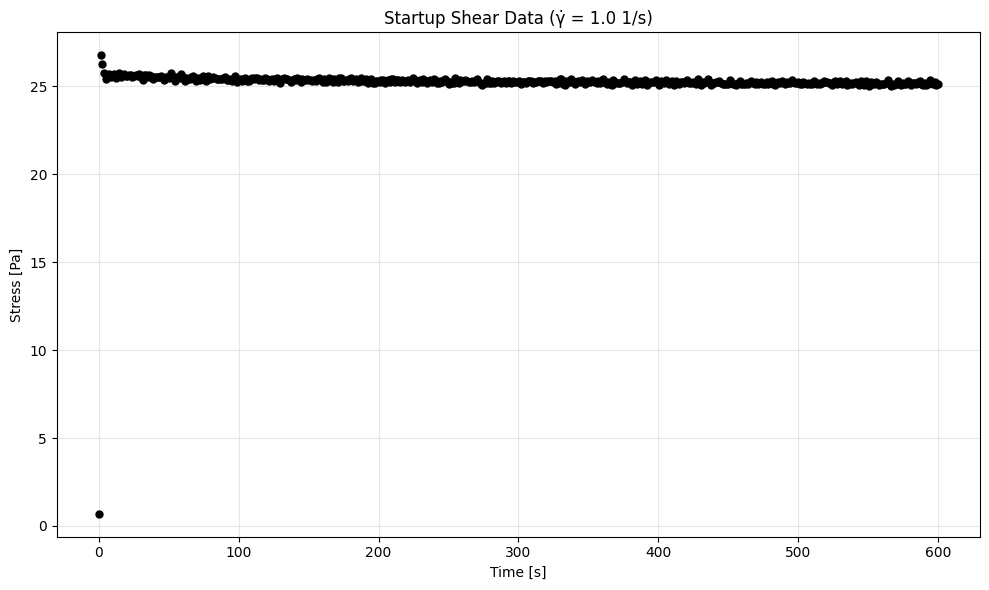

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time_data, stress_data, "ko", markersize=5)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Stress [Pa]")
ax.set_title(f"Startup Shear Data (γ̇ = {GAMMA_DOT} 1/s)")
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

## 3. NLSQ Fitting

In [5]:
N_MODES = 3
model = FMLIKH(n_modes=N_MODES, include_thermal=False, shared_alpha=True, alpha_structure=0.7)

t0 = time.time()
model.fit(time_data, stress_data, test_mode="startup", strain=strain_data, method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nMode info:")
for m in model.get_mode_info()["modes"]:
    print(f"  Mode {m['mode']}: G={m['G']:.4g}, τ={m['tau']:.4g}")

ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/fikh/fmlikh.py", line 532, in _predict
    times, strains = self._extract_time_strain(X, **kwargs)
                     ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/fikh/_base.py", line 335, in _extract_time_strain
    raise ValueError(
    ...<2 lines>...
    )
ValueError: FIKH models require both time and strain history. Pass RheoData, X of shape (2, N), or X=time with strain kwarg.


NLSQ fit time: 1.88 s

Mode info:
  Mode 0: G=1000, τ=1000
  Mode 1: G=157.5, τ=635
  Mode 2: G=20.35, τ=491.5


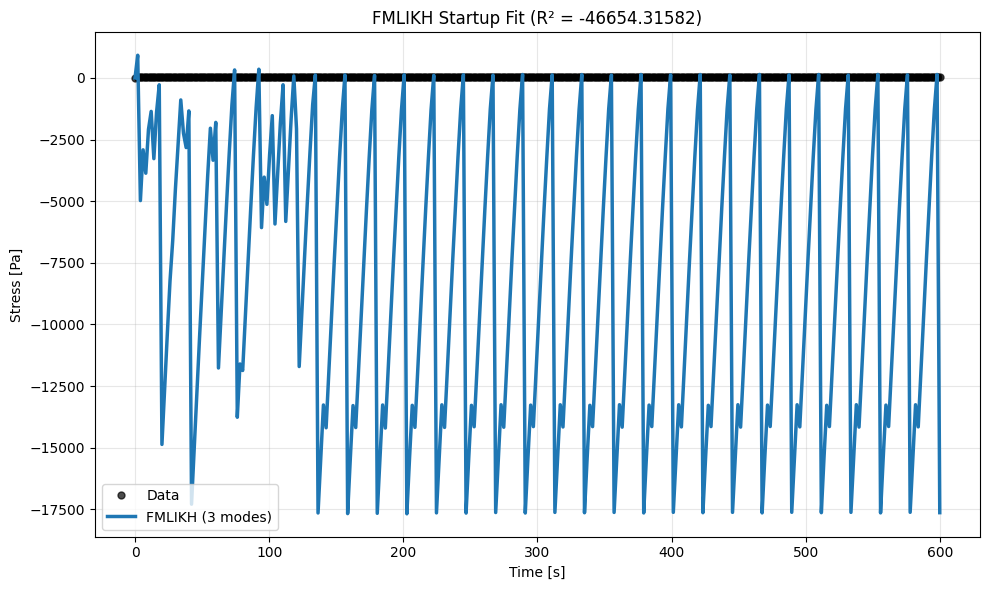

In [6]:
time_fine = np.linspace(0.01, time_data.max(), 300)
strain_fine = GAMMA_DOT * time_fine
stress_pred = model.predict(time_fine, test_mode="startup", strain=strain_fine)

metrics = compute_fit_quality(stress_data, model.predict(time_data, test_mode="startup", strain=strain_data))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time_data, stress_data, "ko", markersize=5, alpha=0.7, label="Data")
ax.plot(time_fine, stress_pred, "-", lw=2.5, color="C0", label=f"FMLIKH ({N_MODES} modes)")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Stress [Pa]")
ax.set_title(f"FMLIKH Startup Fit (R² = {metrics['R2']:.5f})")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. Bayesian Inference

In [7]:
param_names = get_fmlikh_param_names(n_modes=N_MODES, shared_alpha=True)
initial_values = {n: model.parameters.get_value(n) for n in param_names if n in model.parameters}

NUM_WARMUP, NUM_SAMPLES, NUM_CHAINS = 200, 500, 1

t0 = time.time()
result = model.fit_bayesian(
    time_data, stress_data, test_mode="startup", strain=strain_data,
    num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS,
    initial_values=initial_values, seed=42,
)
print(f"Bayesian time: {time.time() - t0:.1f} s")

  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<10:50,  1.07it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   1%|          | 8/700 [00:01<01:16,  9.09it/s, 15 steps of size 5.57e-10. acc. prob=0.05]

warmup:   2%|▏         | 11/700 [00:01<01:02, 11.04it/s, 7 steps of size 5.43e-10. acc. prob=0.31]

warmup:   2%|▏         | 13/700 [00:02<02:23,  4.77it/s, 31 steps of size 6.02e-10. acc. prob=0.41]

warmup:   2%|▏         | 15/700 [00:02<01:56,  5.86it/s, 7 steps of size 8.43e-10. acc. prob=0.49] 

warmup:   2%|▏         | 17/700 [00:03<02:10,  5.24it/s, 7 steps of size 9.93e-10. acc. prob=0.55]

warmup:   3%|▎         | 20/700 [00:03<01:31,  7.43it/s, 3 steps of size 1.85e-09. acc. prob=0.61]

warmup:   3%|▎         | 22/700 [00:03<01:27,  7.76it/s, 3 steps of size 1.44e-09. acc. prob=0.64]

warmup:   3%|▎         | 24/700 [00:04<02:52,  3.93it/s, 31 steps of size 3.48e-10. acc. prob=0.64]

warmup:   4%|▎         | 25/700 [00:05<04:07,  2.72it/s, 127 steps of size 4.32e-10. acc. prob=0.66]

warmup:   4%|▎         | 26/700 [00:05<03:34,  3.14it/s, 15 steps of size 5.44e-10. acc. prob=0.67] 

warmup:   4%|▍         | 28/700 [00:05<02:41,  4.16it/s, 15 steps of size 8.52e-10. acc. prob=0.69]

warmup:   4%|▍         | 31/700 [00:05<01:43,  6.46it/s, 3 steps of size 1.63e-09. acc. prob=0.72] 

warmup:   5%|▍         | 33/700 [00:06<01:26,  7.75it/s, 15 steps of size 1.85e-09. acc. prob=0.74]

warmup:   5%|▌         | 36/700 [00:06<01:04, 10.29it/s, 7 steps of size 2.48e-09. acc. prob=0.75] 

warmup:   5%|▌         | 38/700 [00:06<01:02, 10.64it/s, 15 steps of size 1.67e-09. acc. prob=0.76]

warmup:   6%|▌         | 41/700 [00:06<00:56, 11.59it/s, 15 steps of size 1.76e-09. acc. prob=0.77]

warmup:   6%|▌         | 43/700 [00:06<00:54, 12.10it/s, 3 steps of size 2.12e-09. acc. prob=0.78] 

warmup:   7%|▋         | 46/700 [00:06<00:47, 13.78it/s, 7 steps of size 2.50e-09. acc. prob=0.79]

warmup:   7%|▋         | 49/700 [00:06<00:38, 16.80it/s, 7 steps of size 1.54e-09. acc. prob=0.80]

warmup:   7%|▋         | 51/700 [00:07<00:42, 15.12it/s, 15 steps of size 1.72e-09. acc. prob=0.80]

warmup:   8%|▊         | 53/700 [00:07<00:43, 15.03it/s, 15 steps of size 1.79e-09. acc. prob=0.81]

warmup:   8%|▊         | 55/700 [00:07<00:45, 14.30it/s, 7 steps of size 1.97e-09. acc. prob=0.81] 

warmup:   8%|▊         | 59/700 [00:07<00:33, 19.36it/s, 3 steps of size 2.60e-09. acc. prob=0.82]

warmup:   9%|▉         | 62/700 [00:07<00:45, 13.96it/s, 7 steps of size 1.07e-09. acc. prob=0.82]

warmup:   9%|▉         | 64/700 [00:08<00:42, 14.96it/s, 7 steps of size 1.39e-09. acc. prob=0.83]

warmup:   9%|▉         | 66/700 [00:08<01:15,  8.41it/s, 63 steps of size 6.48e-10. acc. prob=0.82]

warmup:  10%|▉         | 68/700 [00:08<01:07,  9.37it/s, 7 steps of size 8.72e-10. acc. prob=0.83] 

warmup:  10%|█         | 72/700 [00:08<00:46, 13.62it/s, 3 steps of size 1.53e-09. acc. prob=0.84]

warmup:  11%|█         | 75/700 [00:09<00:43, 14.42it/s, 15 steps of size 1.72e-09. acc. prob=0.84]

warmup:  11%|█         | 78/700 [00:09<00:37, 16.71it/s, 3 steps of size 2.28e-09. acc. prob=0.85] 

warmup:  12%|█▏        | 83/700 [00:09<00:32, 19.28it/s, 15 steps of size 1.58e-09. acc. prob=0.85]

warmup:  12%|█▏        | 86/700 [00:09<00:35, 17.32it/s, 7 steps of size 1.87e-09. acc. prob=0.86] 

warmup:  13%|█▎        | 90/700 [00:09<00:31, 19.25it/s, 15 steps of size 1.62e-09. acc. prob=0.86]

warmup:  13%|█▎        | 94/700 [00:09<00:27, 22.22it/s, 3 steps of size 2.34e-09. acc. prob=0.86] 

warmup:  14%|█▍        | 97/700 [00:09<00:26, 23.02it/s, 7 steps of size 2.32e-09. acc. prob=0.87]

warmup:  14%|█▍        | 100/700 [00:10<00:26, 22.25it/s, 3 steps of size 2.34e-09. acc. prob=0.87]

warmup:  15%|█▍        | 103/700 [00:12<02:58,  3.34it/s, 15 steps of size 1.77e-08. acc. prob=0.87]

warmup:  15%|█▌        | 105/700 [00:13<02:34,  3.85it/s, 15 steps of size 1.81e-08. acc. prob=0.87]

warmup:  15%|█▌        | 107/700 [00:13<02:38,  3.74it/s, 15 steps of size 1.90e-08. acc. prob=0.88]

warmup:  16%|█▌        | 109/700 [00:14<02:14,  4.39it/s, 15 steps of size 2.02e-08. acc. prob=0.88]

warmup:  16%|█▌        | 111/700 [00:14<02:30,  3.90it/s, 63 steps of size 2.12e-08. acc. prob=0.88]

warmup:  16%|█▌        | 112/700 [00:14<02:26,  4.02it/s, 31 steps of size 2.18e-08. acc. prob=0.88]

warmup:  16%|█▋        | 114/700 [00:15<01:59,  4.90it/s, 15 steps of size 2.32e-08. acc. prob=0.88]

warmup:  16%|█▋        | 115/700 [00:15<02:28,  3.94it/s, 63 steps of size 2.37e-08. acc. prob=0.88]

warmup:  17%|█▋        | 116/700 [00:15<02:14,  4.36it/s, 15 steps of size 2.44e-08. acc. prob=0.88]

warmup:  17%|█▋        | 117/700 [00:15<02:02,  4.77it/s, 15 steps of size 2.52e-08. acc. prob=0.89]

warmup:  17%|█▋        | 118/700 [00:15<01:52,  5.16it/s, 15 steps of size 2.59e-08. acc. prob=0.89]

warmup:  17%|█▋        | 119/700 [00:16<02:01,  4.78it/s, 31 steps of size 2.65e-08. acc. prob=0.89]

warmup:  17%|█▋        | 121/700 [00:16<01:45,  5.49it/s, 31 steps of size 2.79e-08. acc. prob=0.89]

warmup:  17%|█▋        | 122/700 [00:16<01:34,  6.13it/s, 15 steps of size 2.87e-08. acc. prob=0.89]

warmup:  18%|█▊        | 124/700 [00:16<01:08,  8.44it/s, 7 steps of size 3.03e-08. acc. prob=0.89] 

warmup:  18%|█▊        | 126/700 [00:17<01:20,  7.15it/s, 31 steps of size 3.16e-08. acc. prob=0.89]

warmup:  18%|█▊        | 128/700 [00:17<01:03,  8.99it/s, 7 steps of size 3.32e-08. acc. prob=0.90] 

warmup:  19%|█▊        | 130/700 [00:17<00:53, 10.56it/s, 7 steps of size 3.48e-08. acc. prob=0.90]

warmup:  19%|█▉        | 132/700 [00:17<00:52, 10.90it/s, 7 steps of size 3.63e-08. acc. prob=0.90]

warmup:  19%|█▉        | 134/700 [00:17<00:59,  9.45it/s, 31 steps of size 3.74e-08. acc. prob=0.90]

warmup:  19%|█▉        | 136/700 [00:18<01:14,  7.58it/s, 31 steps of size 3.83e-08. acc. prob=0.90]

warmup:  20%|█▉        | 137/700 [00:18<01:59,  4.69it/s, 63 steps of size 3.02e-08. acc. prob=0.90]

warmup:  20%|█▉        | 138/700 [00:18<01:47,  5.23it/s, 15 steps of size 3.09e-08. acc. prob=0.90]

warmup:  20%|█▉        | 139/700 [00:18<01:36,  5.80it/s, 15 steps of size 3.15e-08. acc. prob=0.90]

warmup:  20%|██        | 140/700 [00:19<01:41,  5.51it/s, 31 steps of size 3.19e-08. acc. prob=0.90]

warmup:  20%|██        | 142/700 [00:19<01:11,  7.78it/s, 7 steps of size 3.33e-08. acc. prob=0.91] 

warmup:  21%|██        | 144/700 [00:20<02:26,  3.80it/s, 7 steps of size 2.89e-08. acc. prob=0.91]

warmup:  21%|██        | 145/700 [00:20<02:22,  3.91it/s, 31 steps of size 2.93e-08. acc. prob=0.91]

warmup:  21%|██        | 147/700 [00:20<01:40,  5.52it/s, 7 steps of size 3.06e-08. acc. prob=0.91] 

warmup:  21%|██▏       | 149/700 [00:20<01:35,  5.76it/s, 15 steps of size 3.15e-08. acc. prob=0.91]

warmup:  21%|██▏       | 150/700 [00:21<02:10,  4.22it/s, 63 steps of size 3.08e-08. acc. prob=0.91]

warmup:  22%|██▏       | 153/700 [00:21<01:22,  6.67it/s, 7 steps of size 1.30e-07. acc. prob=0.91] 

warmup:  22%|██▏       | 157/700 [00:21<00:52, 10.34it/s, 7 steps of size 1.11e-07. acc. prob=0.91]

warmup:  23%|██▎       | 159/700 [00:21<00:54,  9.97it/s, 31 steps of size 2.36e-08. acc. prob=0.91]

warmup:  23%|██▎       | 161/700 [00:22<01:03,  8.53it/s, 31 steps of size 2.51e-08. acc. prob=0.91]

warmup:  23%|██▎       | 163/700 [00:22<01:08,  7.88it/s, 31 steps of size 2.70e-08. acc. prob=0.91]

warmup:  24%|██▎       | 165/700 [00:23<01:23,  6.37it/s, 31 steps of size 2.93e-08. acc. prob=0.91]

warmup:  24%|██▎       | 166/700 [00:23<01:19,  6.73it/s, 15 steps of size 3.06e-08. acc. prob=0.91]

warmup:  24%|██▍       | 168/700 [00:25<03:38,  2.43it/s, 255 steps of size 1.67e-08. acc. prob=0.91]

warmup:  24%|██▍       | 169/700 [00:25<03:07,  2.83it/s, 15 steps of size 1.76e-08. acc. prob=0.91] 

warmup:  24%|██▍       | 170/700 [00:26<04:07,  2.14it/s, 127 steps of size 1.83e-08. acc. prob=0.91]

warmup:  24%|██▍       | 171/700 [00:27<07:04,  1.25it/s, 255 steps of size 1.85e-08. acc. prob=0.91]

warmup:  25%|██▍       | 172/700 [00:31<13:32,  1.54s/it, 475 steps of size 6.33e-09. acc. prob=0.91]

warmup:  25%|██▍       | 173/700 [00:32<11:00,  1.25s/it, 63 steps of size 6.74e-09. acc. prob=0.91] 

warmup:  25%|██▍       | 174/700 [00:32<08:34,  1.02it/s, 31 steps of size 7.16e-09. acc. prob=0.91]

warmup:  25%|██▌       | 175/700 [00:33<08:23,  1.04it/s, 127 steps of size 7.61e-09. acc. prob=0.91]

warmup:  25%|██▌       | 176/700 [00:33<06:47,  1.29it/s, 31 steps of size 8.08e-09. acc. prob=0.91] 

warmup:  25%|██▌       | 177/700 [00:33<05:22,  1.62it/s, 31 steps of size 8.57e-09. acc. prob=0.91]

warmup:  25%|██▌       | 178/700 [00:34<04:25,  1.97it/s, 31 steps of size 9.08e-09. acc. prob=0.92]

warmup:  26%|██▌       | 179/700 [00:34<03:41,  2.35it/s, 31 steps of size 9.61e-09. acc. prob=0.92]

warmup:  26%|██▌       | 180/700 [00:34<03:08,  2.76it/s, 31 steps of size 1.02e-08. acc. prob=0.92]

warmup:  26%|██▌       | 181/700 [00:34<02:28,  3.49it/s, 15 steps of size 1.07e-08. acc. prob=0.92]

warmup:  26%|██▌       | 182/700 [00:35<02:56,  2.93it/s, 63 steps of size 1.13e-08. acc. prob=0.92]

warmup:  26%|██▌       | 183/700 [00:35<02:36,  3.30it/s, 31 steps of size 1.20e-08. acc. prob=0.92]

warmup:  26%|██▋       | 184/700 [00:35<02:27,  3.50it/s, 31 steps of size 1.26e-08. acc. prob=0.92]

warmup:  26%|██▋       | 185/700 [00:35<02:00,  4.28it/s, 15 steps of size 1.33e-08. acc. prob=0.92]

warmup:  27%|██▋       | 186/700 [00:35<01:43,  4.98it/s, 15 steps of size 1.40e-08. acc. prob=0.92]

warmup:  27%|██▋       | 187/700 [00:35<01:32,  5.55it/s, 15 steps of size 1.47e-08. acc. prob=0.92]

warmup:  27%|██▋       | 188/700 [00:36<01:20,  6.36it/s, 15 steps of size 1.54e-08. acc. prob=0.92]

warmup:  27%|██▋       | 189/700 [00:37<03:24,  2.49it/s, 127 steps of size 1.61e-08. acc. prob=0.92]

warmup:  27%|██▋       | 191/700 [00:37<02:07,  3.99it/s, 7 steps of size 1.76e-08. acc. prob=0.92]  

warmup:  28%|██▊       | 193/700 [00:37<01:37,  5.21it/s, 15 steps of size 1.93e-08. acc. prob=0.92]

warmup:  28%|██▊       | 194/700 [00:37<01:43,  4.90it/s, 31 steps of size 2.02e-08. acc. prob=0.92]

warmup:  28%|██▊       | 195/700 [00:37<01:32,  5.46it/s, 15 steps of size 2.10e-08. acc. prob=0.92]

warmup:  28%|██▊       | 196/700 [00:37<01:21,  6.15it/s, 15 steps of size 2.19e-08. acc. prob=0.92]

warmup:  28%|██▊       | 198/700 [00:38<01:05,  7.64it/s, 15 steps of size 2.38e-08. acc. prob=0.92]

warmup:  28%|██▊       | 199/700 [00:38<01:42,  4.87it/s, 63 steps of size 2.46e-08. acc. prob=0.92]

sample:  29%|██▊       | 201/700 [00:38<01:17,  6.41it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  29%|██▉       | 202/700 [00:38<01:14,  6.68it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  29%|██▉       | 203/700 [00:38<01:10,  7.09it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  29%|██▉       | 204/700 [00:39<01:21,  6.08it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  29%|██▉       | 205/700 [00:39<01:15,  6.53it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  29%|██▉       | 206/700 [00:39<01:12,  6.80it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  30%|██▉       | 207/700 [00:39<01:11,  6.91it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  30%|██▉       | 208/700 [00:39<01:11,  6.84it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  30%|██▉       | 209/700 [00:39<01:05,  7.47it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  30%|███       | 210/700 [00:39<01:01,  7.95it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  30%|███       | 211/700 [00:39<00:58,  8.39it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  30%|███       | 212/700 [00:40<00:56,  8.65it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  30%|███       | 213/700 [00:40<01:13,  6.58it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  31%|███       | 214/700 [00:40<01:06,  7.30it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  31%|███       | 215/700 [00:40<01:01,  7.89it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  31%|███       | 216/700 [00:40<01:16,  6.35it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  31%|███       | 217/700 [00:40<01:08,  7.05it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  31%|███▏      | 219/700 [00:41<01:00,  7.96it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  31%|███▏      | 220/700 [00:41<01:16,  6.28it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  32%|███▏      | 221/700 [00:41<01:11,  6.74it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  32%|███▏      | 222/700 [00:41<01:22,  5.80it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  32%|███▏      | 224/700 [00:42<01:19,  6.01it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  32%|███▏      | 225/700 [00:42<01:25,  5.58it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  32%|███▏      | 226/700 [00:42<01:16,  6.21it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  32%|███▏      | 227/700 [00:42<01:09,  6.77it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  33%|███▎      | 229/700 [00:42<01:00,  7.82it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  33%|███▎      | 230/700 [00:43<02:19,  3.37it/s, 127 steps of size 1.71e-08. acc. prob=1.00]

sample:  33%|███▎      | 231/700 [00:43<01:56,  4.02it/s, 15 steps of size 1.71e-08. acc. prob=1.00] 

sample:  33%|███▎      | 232/700 [00:43<01:38,  4.75it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  33%|███▎      | 233/700 [00:44<02:07,  3.67it/s, 63 steps of size 1.71e-08. acc. prob=1.00]

sample:  33%|███▎      | 234/700 [00:44<02:36,  2.97it/s, 63 steps of size 1.71e-08. acc. prob=1.00]

sample:  34%|███▎      | 235/700 [00:44<02:06,  3.69it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  34%|███▎      | 236/700 [00:44<01:42,  4.51it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  34%|███▍      | 237/700 [00:45<01:45,  4.40it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  34%|███▍      | 238/700 [00:45<01:45,  4.39it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  34%|███▍      | 239/700 [00:45<01:30,  5.08it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  34%|███▍      | 240/700 [00:45<01:19,  5.80it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  34%|███▍      | 241/700 [00:46<02:04,  3.70it/s, 63 steps of size 1.71e-08. acc. prob=1.00]

sample:  35%|███▍      | 242/700 [00:46<01:43,  4.41it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  35%|███▍      | 243/700 [00:46<01:26,  5.28it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  35%|███▍      | 244/700 [00:46<01:16,  5.99it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  35%|███▌      | 245/700 [00:46<01:10,  6.41it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  35%|███▌      | 246/700 [00:46<01:19,  5.69it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  35%|███▌      | 247/700 [00:46<01:10,  6.44it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  35%|███▌      | 248/700 [00:46<01:05,  6.88it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  36%|███▌      | 249/700 [00:47<00:59,  7.58it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  36%|███▌      | 250/700 [00:47<00:55,  8.06it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  36%|███▌      | 252/700 [00:47<01:05,  6.84it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  36%|███▌      | 253/700 [00:47<01:02,  7.17it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  36%|███▋      | 254/700 [00:47<00:58,  7.66it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  36%|███▋      | 255/700 [00:47<00:54,  8.09it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  37%|███▋      | 256/700 [00:48<01:10,  6.31it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  37%|███▋      | 257/700 [00:48<01:23,  5.32it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  37%|███▋      | 259/700 [00:49<02:23,  3.07it/s, 127 steps of size 1.71e-08. acc. prob=1.00]

sample:  37%|███▋      | 260/700 [00:49<02:02,  3.59it/s, 15 steps of size 1.71e-08. acc. prob=1.00] 

sample:  37%|███▋      | 261/700 [00:49<01:46,  4.13it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  37%|███▋      | 262/700 [00:49<01:32,  4.76it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  38%|███▊      | 263/700 [00:49<01:19,  5.48it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  38%|███▊      | 264/700 [00:49<01:10,  6.20it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  38%|███▊      | 265/700 [00:50<01:04,  6.75it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  38%|███▊      | 266/700 [00:50<01:00,  7.17it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  38%|███▊      | 267/700 [00:50<00:56,  7.73it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  38%|███▊      | 268/700 [00:50<00:54,  7.89it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  38%|███▊      | 269/700 [00:50<00:51,  8.32it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  39%|███▊      | 270/700 [00:50<00:50,  8.56it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  39%|███▊      | 271/700 [00:50<01:03,  6.71it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  39%|███▉      | 272/700 [00:50<00:58,  7.29it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  39%|███▉      | 273/700 [00:51<00:57,  7.43it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  39%|███▉      | 274/700 [00:51<00:53,  7.98it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  39%|███▉      | 276/700 [00:51<00:49,  8.59it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  40%|███▉      | 277/700 [00:51<00:49,  8.53it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  40%|███▉      | 278/700 [00:51<00:50,  8.43it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  40%|███▉      | 279/700 [00:51<00:50,  8.37it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  40%|████      | 280/700 [00:51<00:50,  8.34it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  40%|████      | 281/700 [00:52<00:48,  8.70it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  40%|████      | 282/700 [00:52<00:48,  8.57it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  40%|████      | 283/700 [00:52<00:50,  8.29it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  41%|████      | 284/700 [00:52<01:02,  6.64it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  41%|████      | 285/700 [00:52<00:57,  7.26it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  41%|████      | 286/700 [00:53<02:34,  2.67it/s, 127 steps of size 1.71e-08. acc. prob=1.00]

sample:  41%|████      | 287/700 [00:53<02:22,  2.89it/s, 31 steps of size 1.71e-08. acc. prob=1.00] 

sample:  41%|████      | 288/700 [00:54<02:44,  2.51it/s, 63 steps of size 1.71e-08. acc. prob=1.00]

sample:  41%|████▏     | 289/700 [00:54<02:11,  3.13it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  41%|████▏     | 290/700 [00:54<01:46,  3.84it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  42%|████▏     | 291/700 [00:54<01:30,  4.51it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  42%|████▏     | 292/700 [00:54<01:17,  5.24it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  42%|████▏     | 293/700 [00:54<01:09,  5.84it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  42%|████▏     | 294/700 [00:55<01:03,  6.36it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  42%|████▏     | 295/700 [00:55<00:57,  7.04it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  42%|████▏     | 297/700 [00:55<01:01,  6.51it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  43%|████▎     | 298/700 [00:55<00:57,  7.05it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  43%|████▎     | 299/700 [00:55<00:54,  7.42it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  43%|████▎     | 300/700 [00:56<01:26,  4.62it/s, 63 steps of size 1.71e-08. acc. prob=1.00]

sample:  43%|████▎     | 301/700 [00:56<01:14,  5.36it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  43%|████▎     | 303/700 [00:56<00:56,  7.04it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  43%|████▎     | 304/700 [00:56<00:53,  7.34it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  44%|████▎     | 305/700 [00:56<00:51,  7.73it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  44%|████▎     | 306/700 [00:56<00:59,  6.66it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  44%|████▍     | 307/700 [00:56<00:54,  7.17it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  44%|████▍     | 308/700 [00:57<00:50,  7.71it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  44%|████▍     | 309/700 [00:57<00:59,  6.52it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  44%|████▍     | 310/700 [00:57<01:06,  5.86it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  44%|████▍     | 311/700 [00:57<00:59,  6.55it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  45%|████▍     | 312/700 [00:57<00:55,  7.01it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  45%|████▍     | 313/700 [00:57<00:53,  7.24it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  45%|████▍     | 314/700 [00:58<01:03,  6.08it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  45%|████▌     | 315/700 [00:58<00:57,  6.73it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  45%|████▌     | 316/700 [00:58<01:04,  5.96it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  45%|████▌     | 317/700 [00:58<00:59,  6.43it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  45%|████▌     | 318/700 [00:58<01:08,  5.59it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  46%|████▌     | 319/700 [00:58<01:02,  6.14it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  46%|████▌     | 320/700 [00:59<00:55,  6.83it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  46%|████▌     | 321/700 [00:59<00:51,  7.30it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  46%|████▌     | 322/700 [00:59<00:49,  7.62it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  46%|████▋     | 324/700 [00:59<00:46,  8.16it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  46%|████▋     | 325/700 [00:59<00:45,  8.23it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  47%|████▋     | 326/700 [00:59<00:43,  8.62it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  47%|████▋     | 327/700 [00:59<00:42,  8.73it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  47%|████▋     | 328/700 [01:00<01:15,  4.90it/s, 63 steps of size 1.71e-08. acc. prob=1.00]

sample:  47%|████▋     | 329/700 [01:00<01:05,  5.71it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  47%|████▋     | 330/700 [01:00<00:56,  6.50it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  47%|████▋     | 331/700 [01:00<00:52,  7.02it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  47%|████▋     | 332/700 [01:00<00:48,  7.56it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  48%|████▊     | 333/700 [01:00<00:46,  7.94it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  48%|████▊     | 334/700 [01:00<00:43,  8.38it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  48%|████▊     | 335/700 [01:00<00:42,  8.66it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  48%|████▊     | 336/700 [01:01<00:52,  6.94it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  48%|████▊     | 337/700 [01:02<02:13,  2.71it/s, 127 steps of size 1.71e-08. acc. prob=1.00]

sample:  48%|████▊     | 338/700 [01:02<01:47,  3.38it/s, 15 steps of size 1.71e-08. acc. prob=1.00] 

sample:  48%|████▊     | 339/700 [01:02<01:28,  4.10it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  49%|████▊     | 340/700 [01:02<01:12,  4.95it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  49%|████▊     | 341/700 [01:02<01:02,  5.73it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  49%|████▉     | 342/700 [01:02<00:54,  6.53it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  49%|████▉     | 343/700 [01:02<00:49,  7.26it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  49%|████▉     | 344/700 [01:02<00:46,  7.66it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  49%|████▉     | 345/700 [01:03<00:45,  7.89it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  49%|████▉     | 346/700 [01:03<00:43,  8.21it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  50%|████▉     | 347/700 [01:03<00:42,  8.33it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  50%|████▉     | 348/700 [01:03<00:53,  6.60it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  50%|████▉     | 349/700 [01:03<00:49,  7.09it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  50%|█████     | 351/700 [01:03<00:42,  8.26it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  50%|█████     | 352/700 [01:03<00:51,  6.81it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  50%|█████     | 353/700 [01:04<00:48,  7.19it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  51%|█████     | 354/700 [01:04<00:44,  7.70it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  51%|█████     | 356/700 [01:04<00:36,  9.54it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  51%|█████     | 357/700 [01:04<00:37,  9.27it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  51%|█████     | 358/700 [01:04<00:37,  9.21it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  51%|█████▏    | 359/700 [01:05<01:48,  3.14it/s, 127 steps of size 1.71e-08. acc. prob=1.00]

sample:  51%|█████▏    | 360/700 [01:05<02:02,  2.78it/s, 63 steps of size 1.71e-08. acc. prob=1.00] 

sample:  52%|█████▏    | 361/700 [01:06<01:37,  3.49it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  52%|█████▏    | 362/700 [01:06<01:20,  4.19it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  52%|█████▏    | 363/700 [01:06<01:07,  4.96it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  52%|█████▏    | 364/700 [01:06<01:08,  4.92it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  52%|█████▏    | 365/700 [01:06<01:01,  5.46it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  52%|█████▏    | 366/700 [01:06<00:53,  6.23it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  52%|█████▏    | 367/700 [01:06<00:59,  5.56it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  53%|█████▎    | 368/700 [01:07<00:57,  5.81it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  53%|█████▎    | 369/700 [01:07<00:53,  6.17it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  53%|█████▎    | 370/700 [01:07<00:58,  5.63it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  53%|█████▎    | 371/700 [01:07<00:52,  6.21it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  53%|█████▎    | 372/700 [01:07<00:48,  6.72it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  53%|█████▎    | 373/700 [01:07<00:55,  5.87it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  54%|█████▎    | 375/700 [01:08<01:49,  2.97it/s, 127 steps of size 1.71e-08. acc. prob=1.00]

sample:  54%|█████▎    | 376/700 [01:09<01:31,  3.54it/s, 15 steps of size 1.71e-08. acc. prob=1.00] 

sample:  54%|█████▍    | 377/700 [01:09<01:48,  2.97it/s, 63 steps of size 1.71e-08. acc. prob=1.00]

sample:  54%|█████▍    | 378/700 [01:09<01:38,  3.27it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  54%|█████▍    | 379/700 [01:10<01:34,  3.41it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  54%|█████▍    | 380/700 [01:10<01:16,  4.17it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  54%|█████▍    | 381/700 [01:10<01:15,  4.25it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  55%|█████▍    | 382/700 [01:10<01:02,  5.06it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  55%|█████▍    | 383/700 [01:10<00:54,  5.78it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  55%|█████▍    | 384/700 [01:10<00:58,  5.36it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  55%|█████▌    | 386/700 [01:11<00:42,  7.35it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  55%|█████▌    | 387/700 [01:11<00:42,  7.44it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  55%|█████▌    | 388/700 [01:11<00:40,  7.76it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  56%|█████▌    | 389/700 [01:11<00:48,  6.37it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  56%|█████▌    | 390/700 [01:11<00:44,  7.03it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  56%|█████▌    | 391/700 [01:11<00:40,  7.58it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  56%|█████▌    | 392/700 [01:12<01:08,  4.52it/s, 63 steps of size 1.71e-08. acc. prob=1.00]

sample:  56%|█████▌    | 393/700 [01:12<00:57,  5.37it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  56%|█████▋    | 394/700 [01:12<00:58,  5.27it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  56%|█████▋    | 395/700 [01:12<00:51,  5.92it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  57%|█████▋    | 396/700 [01:12<00:48,  6.28it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  57%|█████▋    | 397/700 [01:12<00:44,  6.74it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  57%|█████▋    | 398/700 [01:12<00:40,  7.38it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  57%|█████▋    | 399/700 [01:13<00:38,  7.79it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  57%|█████▋    | 400/700 [01:13<00:37,  8.09it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  57%|█████▋    | 401/700 [01:13<00:45,  6.53it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  57%|█████▋    | 402/700 [01:13<00:43,  6.82it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  58%|█████▊    | 404/700 [01:13<00:42,  6.95it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  58%|█████▊    | 405/700 [01:13<00:39,  7.43it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  58%|█████▊    | 406/700 [01:14<00:45,  6.51it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  58%|█████▊    | 407/700 [01:14<00:42,  6.95it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  58%|█████▊    | 409/700 [01:14<00:34,  8.41it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  59%|█████▊    | 410/700 [01:14<00:33,  8.56it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  59%|█████▊    | 411/700 [01:14<00:33,  8.68it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  59%|█████▉    | 412/700 [01:14<00:41,  6.95it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  59%|█████▉    | 413/700 [01:15<01:03,  4.54it/s, 63 steps of size 1.71e-08. acc. prob=1.00]

sample:  59%|█████▉    | 414/700 [01:15<00:54,  5.21it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  59%|█████▉    | 415/700 [01:15<01:00,  4.69it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  59%|█████▉    | 416/700 [01:15<01:04,  4.42it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  60%|█████▉    | 417/700 [01:16<00:54,  5.15it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  60%|█████▉    | 418/700 [01:16<00:47,  5.92it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  60%|█████▉    | 419/700 [01:16<00:43,  6.41it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  60%|██████    | 420/700 [01:16<00:39,  7.03it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  60%|██████    | 421/700 [01:16<00:36,  7.61it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  60%|██████    | 423/700 [01:17<00:54,  5.06it/s, 63 steps of size 1.71e-08. acc. prob=1.00]

sample:  61%|██████    | 424/700 [01:17<00:48,  5.68it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  61%|██████    | 425/700 [01:17<00:43,  6.38it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  61%|██████    | 426/700 [01:17<00:47,  5.82it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  61%|██████    | 427/700 [01:17<00:42,  6.41it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  61%|██████    | 428/700 [01:17<01:04,  4.20it/s, 63 steps of size 1.71e-08. acc. prob=1.00]

sample:  61%|██████▏   | 429/700 [01:18<00:54,  4.97it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  61%|██████▏   | 430/700 [01:18<00:47,  5.69it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  62%|██████▏   | 431/700 [01:18<01:07,  4.00it/s, 63 steps of size 1.71e-08. acc. prob=1.00]

sample:  62%|██████▏   | 432/700 [01:18<00:56,  4.78it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  62%|██████▏   | 433/700 [01:18<00:47,  5.59it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  62%|██████▏   | 434/700 [01:18<00:41,  6.39it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  62%|██████▏   | 435/700 [01:19<00:46,  5.73it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  62%|██████▏   | 436/700 [01:19<00:51,  5.14it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  62%|██████▏   | 437/700 [01:19<00:53,  4.96it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  63%|██████▎   | 438/700 [01:19<00:46,  5.66it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  63%|██████▎   | 439/700 [01:20<01:07,  3.86it/s, 63 steps of size 1.71e-08. acc. prob=1.00]

sample:  63%|██████▎   | 440/700 [01:20<00:56,  4.60it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  63%|██████▎   | 441/700 [01:20<00:47,  5.45it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  63%|██████▎   | 443/700 [01:20<00:34,  7.54it/s, 7 steps of size 1.71e-08. acc. prob=1.00] 

sample:  64%|██████▎   | 445/700 [01:20<00:30,  8.23it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  64%|██████▎   | 446/700 [01:20<00:30,  8.45it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  64%|██████▍   | 448/700 [01:21<00:25,  9.87it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  64%|██████▍   | 450/700 [01:21<00:26,  9.43it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  65%|██████▍   | 452/700 [01:21<00:23, 10.60it/s, 7 steps of size 1.71e-08. acc. prob=1.00] 

sample:  65%|██████▍   | 454/700 [01:21<00:23, 10.40it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  65%|██████▌   | 456/700 [01:22<00:33,  7.31it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  65%|██████▌   | 457/700 [01:22<00:31,  7.65it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  65%|██████▌   | 458/700 [01:22<00:30,  7.92it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  66%|██████▌   | 459/700 [01:22<00:30,  7.99it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  66%|██████▌   | 460/700 [01:22<00:28,  8.33it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  66%|██████▌   | 461/700 [01:22<00:29,  7.99it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  66%|██████▌   | 462/700 [01:22<00:34,  6.82it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  66%|██████▌   | 463/700 [01:22<00:32,  7.33it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  66%|██████▋   | 464/700 [01:23<00:29,  7.88it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  66%|██████▋   | 465/700 [01:23<00:29,  8.05it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  67%|██████▋   | 466/700 [01:23<00:36,  6.40it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  67%|██████▋   | 467/700 [01:23<00:33,  7.04it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  67%|██████▋   | 468/700 [01:23<00:39,  5.89it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  67%|██████▋   | 469/700 [01:23<00:42,  5.42it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  67%|██████▋   | 470/700 [01:24<00:37,  6.20it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  67%|██████▋   | 471/700 [01:24<00:54,  4.19it/s, 63 steps of size 1.71e-08. acc. prob=1.00]

sample:  67%|██████▋   | 472/700 [01:24<00:45,  4.96it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  68%|██████▊   | 473/700 [01:25<01:32,  2.45it/s, 127 steps of size 1.71e-08. acc. prob=1.00]

sample:  68%|██████▊   | 474/700 [01:25<01:11,  3.16it/s, 15 steps of size 1.71e-08. acc. prob=1.00] 

sample:  68%|██████▊   | 476/700 [01:25<00:48,  4.61it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  68%|██████▊   | 478/700 [01:25<00:36,  6.15it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  68%|██████▊   | 479/700 [01:26<00:32,  6.70it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  69%|██████▊   | 480/700 [01:26<00:30,  7.27it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  69%|██████▊   | 481/700 [01:27<01:13,  3.00it/s, 127 steps of size 1.71e-08. acc. prob=1.00]

sample:  69%|██████▉   | 482/700 [01:27<00:59,  3.64it/s, 15 steps of size 1.71e-08. acc. prob=1.00] 

sample:  69%|██████▉   | 483/700 [01:27<01:09,  3.10it/s, 63 steps of size 1.71e-08. acc. prob=1.00]

sample:  69%|██████▉   | 484/700 [01:27<00:57,  3.75it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  69%|██████▉   | 485/700 [01:27<00:47,  4.49it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  69%|██████▉   | 486/700 [01:27<00:40,  5.29it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  70%|██████▉   | 487/700 [01:28<00:35,  6.00it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  70%|██████▉   | 488/700 [01:28<00:38,  5.48it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  70%|██████▉   | 489/700 [01:28<00:33,  6.26it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  70%|███████   | 490/700 [01:28<00:30,  6.86it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  70%|███████   | 491/700 [01:28<00:27,  7.49it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  70%|███████   | 492/700 [01:28<00:26,  7.92it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  71%|███████   | 494/700 [01:28<00:25,  8.20it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  71%|███████   | 495/700 [01:29<00:24,  8.24it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  71%|███████   | 496/700 [01:29<00:23,  8.63it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  71%|███████   | 497/700 [01:29<00:23,  8.75it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  71%|███████   | 498/700 [01:29<00:23,  8.69it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  71%|███████▏  | 500/700 [01:29<00:19, 10.06it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  72%|███████▏  | 501/700 [01:29<00:20,  9.77it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  72%|███████▏  | 502/700 [01:29<00:21,  9.43it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  72%|███████▏  | 503/700 [01:29<00:21,  9.35it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  72%|███████▏  | 504/700 [01:30<00:20,  9.44it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  72%|███████▏  | 505/700 [01:30<00:21,  9.27it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  72%|███████▏  | 506/700 [01:30<00:22,  8.77it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  72%|███████▏  | 507/700 [01:30<00:28,  6.75it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  73%|███████▎  | 508/700 [01:30<00:28,  6.71it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  73%|███████▎  | 510/700 [01:30<00:30,  6.32it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  73%|███████▎  | 511/700 [01:31<00:27,  6.91it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  73%|███████▎  | 513/700 [01:31<00:35,  5.26it/s, 63 steps of size 1.71e-08. acc. prob=1.00]

sample:  73%|███████▎  | 514/700 [01:31<00:31,  5.85it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  74%|███████▎  | 515/700 [01:31<00:35,  5.17it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  74%|███████▎  | 516/700 [01:32<00:31,  5.84it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  74%|███████▍  | 517/700 [01:32<00:28,  6.33it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  74%|███████▍  | 518/700 [01:32<00:43,  4.20it/s, 63 steps of size 1.71e-08. acc. prob=1.00]

sample:  74%|███████▍  | 519/700 [01:32<00:43,  4.19it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  74%|███████▍  | 521/700 [01:33<00:31,  5.67it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  75%|███████▍  | 522/700 [01:33<00:29,  5.99it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  75%|███████▍  | 523/700 [01:33<00:27,  6.47it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  75%|███████▍  | 524/700 [01:33<00:26,  6.71it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  75%|███████▌  | 525/700 [01:33<00:24,  7.26it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  75%|███████▌  | 527/700 [01:33<00:20,  8.34it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  75%|███████▌  | 528/700 [01:34<00:25,  6.82it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  76%|███████▌  | 529/700 [01:34<00:28,  6.00it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  76%|███████▌  | 530/700 [01:34<00:26,  6.48it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  76%|███████▌  | 531/700 [01:34<00:24,  6.99it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  76%|███████▌  | 532/700 [01:34<00:23,  7.21it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  76%|███████▌  | 533/700 [01:34<00:22,  7.54it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  76%|███████▋  | 534/700 [01:34<00:26,  6.35it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  76%|███████▋  | 535/700 [01:35<00:23,  6.97it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  77%|███████▋  | 536/700 [01:35<00:23,  7.12it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  77%|███████▋  | 537/700 [01:35<00:20,  7.78it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  77%|███████▋  | 538/700 [01:35<00:36,  4.49it/s, 63 steps of size 1.71e-08. acc. prob=1.00]

sample:  77%|███████▋  | 539/700 [01:35<00:30,  5.35it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  77%|███████▋  | 540/700 [01:35<00:27,  5.83it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  77%|███████▋  | 542/700 [01:36<00:20,  7.60it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  78%|███████▊  | 544/700 [01:36<00:20,  7.62it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  78%|███████▊  | 546/700 [01:36<00:17,  8.99it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  78%|███████▊  | 547/700 [01:36<00:17,  8.66it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  78%|███████▊  | 548/700 [01:36<00:17,  8.88it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  78%|███████▊  | 549/700 [01:36<00:17,  8.62it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  79%|███████▊  | 550/700 [01:37<00:18,  8.08it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  79%|███████▉  | 552/700 [01:37<00:14, 10.51it/s, 7 steps of size 1.71e-08. acc. prob=1.00] 

sample:  79%|███████▉  | 554/700 [01:37<00:18,  7.94it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  79%|███████▉  | 555/700 [01:37<00:17,  8.19it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  79%|███████▉  | 556/700 [01:37<00:17,  8.13it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  80%|███████▉  | 557/700 [01:37<00:16,  8.47it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  80%|███████▉  | 558/700 [01:37<00:16,  8.78it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  80%|███████▉  | 559/700 [01:38<00:19,  7.18it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  80%|████████  | 560/700 [01:38<00:18,  7.77it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  80%|████████  | 561/700 [01:38<00:17,  8.02it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  80%|████████  | 562/700 [01:38<00:16,  8.12it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  80%|████████  | 563/700 [01:38<00:16,  8.43it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  81%|████████  | 564/700 [01:38<00:16,  8.17it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  81%|████████  | 565/700 [01:38<00:20,  6.68it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  81%|████████  | 566/700 [01:39<00:23,  5.77it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  81%|████████  | 567/700 [01:39<00:21,  6.31it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  81%|████████▏ | 569/700 [01:39<00:16,  7.83it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  81%|████████▏ | 570/700 [01:39<00:26,  4.93it/s, 63 steps of size 1.71e-08. acc. prob=1.00]

sample:  82%|████████▏ | 571/700 [01:40<00:26,  4.84it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  82%|████████▏ | 572/700 [01:40<00:23,  5.52it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  82%|████████▏ | 574/700 [01:40<00:15,  8.03it/s, 7 steps of size 1.71e-08. acc. prob=1.00] 

sample:  82%|████████▏ | 576/700 [01:40<00:22,  5.41it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  82%|████████▏ | 577/700 [01:41<00:23,  5.16it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  83%|████████▎ | 578/700 [01:41<00:21,  5.68it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  83%|████████▎ | 579/700 [01:41<00:19,  6.24it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  83%|████████▎ | 580/700 [01:41<00:30,  3.94it/s, 63 steps of size 1.71e-08. acc. prob=1.00]

sample:  83%|████████▎ | 581/700 [01:42<00:26,  4.50it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  83%|████████▎ | 582/700 [01:42<00:22,  5.24it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  83%|████████▎ | 584/700 [01:42<00:17,  6.45it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  84%|████████▎ | 585/700 [01:42<00:16,  6.86it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  84%|████████▍ | 587/700 [01:42<00:13,  8.28it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  84%|████████▍ | 588/700 [01:42<00:15,  7.16it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  84%|████████▍ | 589/700 [01:42<00:15,  7.15it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  84%|████████▍ | 590/700 [01:43<00:24,  4.49it/s, 63 steps of size 1.71e-08. acc. prob=1.00]

sample:  84%|████████▍ | 591/700 [01:43<00:20,  5.25it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  85%|████████▍ | 592/700 [01:43<00:17,  6.05it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  85%|████████▍ | 593/700 [01:43<00:15,  6.75it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  85%|████████▌ | 595/700 [01:43<00:11,  8.95it/s, 7 steps of size 1.71e-08. acc. prob=1.00] 

sample:  85%|████████▌ | 597/700 [01:44<00:11,  9.08it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  86%|████████▌ | 599/700 [01:44<00:12,  8.11it/s, 7 steps of size 1.71e-08. acc. prob=1.00] 

sample:  86%|████████▌ | 600/700 [01:44<00:11,  8.39it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  86%|████████▌ | 601/700 [01:45<00:30,  3.25it/s, 127 steps of size 1.71e-08. acc. prob=1.00]

sample:  86%|████████▌ | 603/700 [01:45<00:21,  4.55it/s, 15 steps of size 1.71e-08. acc. prob=1.00] 

sample:  86%|████████▋ | 604/700 [01:45<00:19,  4.94it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  86%|████████▋ | 605/700 [01:45<00:17,  5.53it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  87%|████████▋ | 608/700 [01:46<00:11,  8.19it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  87%|████████▋ | 610/700 [01:46<00:10,  8.77it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  87%|████████▋ | 612/700 [01:46<00:10,  8.80it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  88%|████████▊ | 613/700 [01:46<00:09,  8.89it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  88%|████████▊ | 614/700 [01:46<00:09,  8.70it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  88%|████████▊ | 615/700 [01:46<00:10,  8.39it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  88%|████████▊ | 616/700 [01:46<00:09,  8.55it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  88%|████████▊ | 617/700 [01:47<00:09,  8.72it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  88%|████████▊ | 619/700 [01:47<00:08,  9.95it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  89%|████████▊ | 621/700 [01:47<00:06, 12.01it/s, 7 steps of size 1.71e-08. acc. prob=1.00] 

sample:  89%|████████▉ | 623/700 [01:47<00:06, 12.07it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  89%|████████▉ | 625/700 [01:47<00:07, 10.08it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  90%|████████▉ | 627/700 [01:47<00:07,  9.93it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  90%|████████▉ | 629/700 [01:48<00:06, 11.44it/s, 7 steps of size 1.71e-08. acc. prob=1.00] 

sample:  90%|█████████ | 631/700 [01:48<00:06, 10.81it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  90%|█████████ | 633/700 [01:48<00:06, 10.18it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  91%|█████████ | 635/700 [01:48<00:07,  8.67it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  91%|█████████ | 636/700 [01:48<00:07,  8.37it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  91%|█████████ | 637/700 [01:49<00:07,  8.30it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  91%|█████████ | 638/700 [01:49<00:07,  8.33it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  91%|█████████▏| 639/700 [01:49<00:08,  6.98it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  91%|█████████▏| 640/700 [01:49<00:08,  7.37it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  92%|█████████▏| 641/700 [01:49<00:09,  6.10it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  92%|█████████▏| 642/700 [01:50<00:10,  5.60it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  92%|█████████▏| 643/700 [01:50<00:09,  6.33it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  92%|█████████▏| 644/700 [01:50<00:08,  6.90it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  92%|█████████▏| 645/700 [01:50<00:07,  7.40it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  92%|█████████▏| 647/700 [01:50<00:07,  7.13it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  93%|█████████▎| 648/700 [01:50<00:06,  7.46it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  93%|█████████▎| 649/700 [01:50<00:06,  7.47it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  93%|█████████▎| 650/700 [01:51<00:06,  7.55it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  93%|█████████▎| 651/700 [01:51<00:06,  7.67it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  93%|█████████▎| 652/700 [01:51<00:06,  7.94it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample:  93%|█████████▎| 654/700 [01:51<00:04, 10.34it/s, 7 steps of size 1.71e-08. acc. prob=1.00] 

sample:  94%|█████████▎| 656/700 [01:53<00:23,  1.89it/s, 315 steps of size 1.71e-08. acc. prob=1.00]

sample:  94%|█████████▍| 658/700 [01:53<00:15,  2.78it/s, 7 steps of size 1.71e-08. acc. prob=1.00]  

sample:  94%|█████████▍| 660/700 [01:54<00:10,  3.92it/s, 7 steps of size 1.71e-08. acc. prob=1.00]

sample:  95%|█████████▍| 662/700 [01:54<00:07,  5.01it/s, 7 steps of size 1.71e-08. acc. prob=1.00]

sample:  95%|█████████▍| 664/700 [01:54<00:05,  6.50it/s, 7 steps of size 1.71e-08. acc. prob=1.00]

sample:  95%|█████████▌| 666/700 [01:54<00:04,  7.98it/s, 7 steps of size 1.71e-08. acc. prob=1.00]

sample:  95%|█████████▌| 668/700 [01:54<00:03,  9.13it/s, 7 steps of size 1.71e-08. acc. prob=1.00]

sample:  96%|█████████▌| 670/700 [01:54<00:02, 10.90it/s, 7 steps of size 1.71e-08. acc. prob=1.00]

sample:  96%|█████████▌| 672/700 [01:54<00:02, 12.64it/s, 7 steps of size 1.71e-08. acc. prob=1.00]

sample:  96%|█████████▋| 674/700 [01:55<00:02,  9.54it/s, 7 steps of size 1.71e-08. acc. prob=1.00]

sample:  97%|█████████▋| 676/700 [01:55<00:02, 10.96it/s, 7 steps of size 1.71e-08. acc. prob=1.00]

sample:  97%|█████████▋| 678/700 [01:55<00:01, 12.61it/s, 7 steps of size 1.71e-08. acc. prob=1.00]

sample:  97%|█████████▋| 680/700 [01:55<00:02,  9.37it/s, 31 steps of size 1.71e-08. acc. prob=1.00]

sample:  97%|█████████▋| 682/700 [01:55<00:01, 10.51it/s, 7 steps of size 1.71e-08. acc. prob=1.00] 

sample:  98%|█████████▊| 684/700 [01:56<00:01,  9.24it/s, 7 steps of size 1.71e-08. acc. prob=1.00]

sample:  98%|█████████▊| 686/700 [01:56<00:01, 10.53it/s, 7 steps of size 1.71e-08. acc. prob=1.00]

sample:  98%|█████████▊| 689/700 [01:56<00:00, 12.59it/s, 7 steps of size 1.71e-08. acc. prob=1.00]

sample:  99%|█████████▊| 691/700 [01:56<00:00, 13.03it/s, 7 steps of size 1.71e-08. acc. prob=1.00]

sample:  99%|█████████▉| 693/700 [01:56<00:00, 13.55it/s, 7 steps of size 1.71e-08. acc. prob=1.00]

sample:  99%|█████████▉| 695/700 [01:56<00:00, 13.44it/s, 15 steps of size 1.71e-08. acc. prob=1.00]

sample: 100%|█████████▉| 697/700 [01:56<00:00, 14.26it/s, 7 steps of size 1.71e-08. acc. prob=1.00] 

sample: 100%|█████████▉| 699/700 [01:57<00:00, 15.32it/s, 7 steps of size 1.71e-08. acc. prob=1.00]

sample: 100%|██████████| 700/700 [01:57<00:00,  5.98it/s, 7 steps of size 1.71e-08. acc. prob=1.00]

Bayesian time: 121.1 s


In [8]:
key_params = ["G_0", "G_1", "alpha_structure", "sigma_y0"]
print_convergence_summary(result, key_params)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
            G_0    1.0000       500      PASS
            G_1    1.0000       500      PASS
alpha_structure    1.0000       500      PASS
       sigma_y0    1.0000       500      PASS

Divergences: 1

CHECK REQUIRED: Increase num_warmup/num_samples or check warm-start


False

## 5. Save Results

In [9]:
save_fikh_results(model, result, "fmlikh", "startup", param_names)

Results saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/fikh/fmlikh/startup/
  nlsq_params_startup.json: 20 parameters
  posterior_startup.json: 500 draws


## Key Takeaways

1. **Multi-mode captures complex overshoot** behavior
2. **Each mode contributes** at its characteristic time scale
3. **Shared alpha** maintains fractional memory across modes
4. **More modes** → better fit but more parameters